# 神经网络解常微分方程例子

In [1]:
from ode_example.forward_problem.model import *
from ode_example.forward_problem.data import *
from ode_example.forward_problem.criterion import *
from ode_example.forward_problem.train import *

In [2]:
# %pylab
# %matplotlib qt5

## 1. 正问题(forward problem)
所谓正问题即已知偏微分方程的形式，初始条件、边界条件，对其进行求解。在ode_example/forward_problem/文件夹下给了一个非常简单的例子，即求解如下常微分方程

$$
\left\{\begin{aligned}
&\frac{dy}{dx} = 1 \\
& y(0) = 0 \\ 
& x \in [0, 4]
\end{aligned}\right.$$

Step 999 - lr 0.0001 -  loss: 0.0032575593423098325


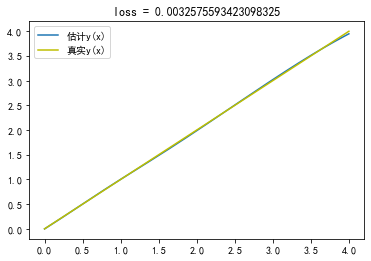

In [4]:
model = SolveOde(5, 30) # 3 layer 30 node
data_sampler = DataSampler(100, 1)  # 100 data, 1 boundary data
criterion = Criterion(model, data_sampler)

train = Train(criterion)
train.train(1000, 1e-4)

而它对应的期望损失函数为

$$ loss = E_{x\sim U_[0, 4]}[||\frac{dy}{dx} - 1||^2] + E_{x \sim U_{\{0\}}}[||y(x)||^2]$$

离散成经验损失函数(empirical loss function)，对应pytorch代码如下
```
x_batch, x_0 = self.data_sampler.sample()
x_batch.requires_grad = True
y_batch = self.model(x_batch)
y_0 = self.model(x_0)
jacob_matrix = torch.autograd.grad(y_batch, x_batch, grad_outputs=torch.ones_like(y_batch),
                                   create_graph=True)
dy_dx = jacob_matrix[0][:, 0].reshape(-1, 1)
# ode loss + initial loss
error = torch.mean((dy_dx - 1) ** 2) + torch.mean(y_0 ** 2)
```

## 2. 逆问题(inverse problem)
所谓逆问题即已知偏微分方程的形式，并且对解有**一组观测**，需要**估计方程中的参数**(常数或也是自变量的函数)。在ode_example/inverse_problem/文件夹下给了一个非常简单的例子，即对上一节正问题中方程的解有一组观测，需要估计参数函数$k(x) = 1$。

$$
\left\{\begin{aligned}
&k(x)\frac{dy}{dx} = 1 \\
& y(0) = 0 \\ 
& x \in [0, 4]
\end{aligned}\right.$$

Step 999 - lr 0.0003 -  loss: 2.935027823448181


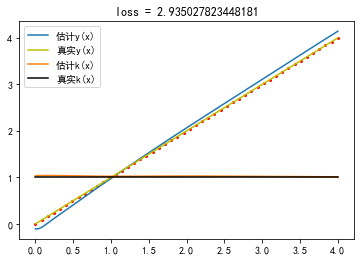

In [7]:
from ode_example.inverse_problem.model import *
from ode_example.inverse_problem.data import *
from ode_example.inverse_problem.criterion import *
from ode_example.inverse_problem.train import *
import torch


model = EstimateCond(3, 30, 3, 330)
# model = torch.load("model.pth")

x = torch.linspace(0, 4, 50, dtype=torch.float32).reshape(-1, 1)
observe_x_y = torch.cat([x, x], dim=1)
# print("observe_x_y.shape = ", observe_x_y.shape)

data_sampler = DataSampler(100, 1, 30, observe_x_y)  # 100 data, 1 boundary data
criterion = Criterion(model, data_sampler)

train = Train(criterion)
train.train(1000, 3e-4)

目前有非常多将PINN(physical-informed neural network)应用在各种物理参数预测的文章，其基本的原理和这个常微分方程类似。数值实验表明，使用更宽、更浅的神经网络反而可以更快地收敛到较好地解，这和神经网络在CV,NLP中的结论是相反的。

3. 参考文献

[1] Maziar R , Alireza Y , Em K G . Hidden fluid mechanics: Learning velocity and pressure fields from flow visualizations[J]. Science (New York, N.Y.), 2020, 2020年367卷6481期:1026-1030页.

[2] Lu L , X Meng, Mao Z , et al. DeepXDE: A deep learning library for solving differential equations[J]. SIAM Review, 2021, 63(1):208-228.

[3] Lu L , Pestourie R , Yao W , et al. Physics-informed neural networks with hard constraints for inverse design[J]. 2021.


[4] Kissas G , Yang Y , Hwuang E , et al. Machine learning in cardiovascular flows modeling: Predicting arterial blood pressure from non-invasive 4D flow MRI data using physics-informed neural networks[J]. 2019.